In [7]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
torch.manual_seed(0)
from tqdm import tqdm
import numpy as np

In [8]:
### unet for a diffusion model

class UnetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, time_emb_dim, up=True):
    super().__init__()
    self.time_transform = nn.Linear(time_emb_dim, out_channels)

    if up:
      self.conv1 = nn.Conv2d(2*in_channels, out_channels, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
      self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

    self.activation = nn.ReLU()
    self.bnorm1 = nn.BatchNorm2d(out_channels)
    self.bnorm2 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

  def forward(self, x, time):
    ## time embedding
    time = self.activation(self.time_transform(time))
    time = time[(..., ) + (None, )*2]

    x = self.bnorm1(self.activation(self.conv1(x)))
    x = x + time

    x = self.bnorm2(self.activation(self.conv2(x)))
    x = self.transform(x)

    return x



class Unet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, start_dim=32, dim_mult=[2, 4, 8], time_emb_dim=32):
    super().__init__()
    self.in_channels = in_channels
    down_channels = [start_dim * i for i in dim_mult]
    up_channels = down_channels[::-1]

    self.time_transform = nn.Sequential(
        TimeEmbedding(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )

    self.conv0 = nn.Conv2d(in_channels, down_channels[0], 3, padding=1)

    self.down = nn.ModuleList([UnetBlock(down_channels[i], down_channels[i+1],\
                                         time_emb_dim, up=False) for i in range(len(down_channels) - 1)])

    self.up = nn.ModuleList([UnetBlock(up_channels[i], up_channels[i+1],\
                                         time_emb_dim, up=True) for i in range(len(up_channels) - 1)])

    self.out_conv = nn.Conv2d(up_channels[-1], out_channels, 1)

  def forward(self, x, time):
    time = self.time_transform(time)

    res_outputs = []
    x = self.conv0(x)
    for block in self.down:
      x = block(x, time)
      res_outputs.append(x)

    for block in self.up:
      residual_x = res_outputs.pop()
      x = torch.cat((x, residual_x), dim=1)

      x = block(x, time)

    x = self.out_conv(x)
    return x

In [9]:
class TimeEmbedding(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device

    half_dim = self.dim // 2
    embeddings = torch.exp(torch.arange(half_dim, device=device) * (-math.log(10000) / (half_dim-1)))
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

In [27]:
class Diffusion:
  def __init__(self, in_channels=1, out_channels=1, start_dim=32, dim_mult=[2,4,8], time_emb_dim=32, img_size=28, T=300, start_beta=1e-4, end_beta=0.2, device='cpu', batch_size=64, data='mnist'):

    self.model = Unet(in_channels, out_channels, start_dim, dim_mult, time_emb_dim)
    self.betas = self.linear_beta_schedule(T, start_beta, end_beta)
    self.alphas = 1. - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
    self.img_size = img_size
    self.in_channels = in_channels
    self.T = T
    self.device = device
    self.batch_size = batch_size
    self.data = data
    self.dataloader = self.get_dataloader()



  def linear_beta_schedule(self, timesteps, start_beta=0.0001, end_beta=0.02):
    return torch.linspace(start_beta, end_beta, timesteps)

  def get_index_from_list(self, vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


  def forward_diffusion_sample(self, x0, t, device='cpu'):

    sqrt_alpha_cumprod_t = torch.sqrt(self.get_index_from_list(self.alphas_cumprod, t, x0.shape))
    noise = torch.randn_like(x0)

    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(self.get_index_from_list(1 - self.alphas_cumprod, t, x0.shape))

    return x0.to(device) * sqrt_alpha_cumprod_t.to(device) + \
    sqrt_one_minus_alpha_cumprod_t.to(device) * noise.to(device), noise.to(device)


  @staticmethod
  def show_tensor_image(img):
    image_tensor = (img + 1) / 2
    image_tensor = image_tensor.permute(0,2,3,1)
    plt.imshow(image_tensor.squeeze())

  @torch.no_grad()
  def sample_timestep(self, x, t):
    alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1,0), value=1.0)
    alpha_cumprod_t = self.get_index_from_list(self.alphas_cumprod, t, x.shape)
    betas_t = self.get_index_from_list(self.betas, t, x.shape)
    sigma = (1. - alphas_cumprod_prev) / (1. - self.alphas_cumprod) * self.betas
    sqrt_sigma_t = torch.sqrt(self.get_index_from_list(sigma, t, x.shape))
    model_mean = (x - betas_t / torch.sqrt(1 - alpha_cumprod_t) * self.model(x, t))

    if t == 0:
      return model_mean
    else:
      noise = torch.randn_like(x)
      return model_mean + sqrt_sigma_t * noise

  @torch.no_grad()
  def plot_sampled_images(self):
    img = torch.randn((1, self.in_channels, self.img_size, self.img_size), device=self.device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(self.T/num_images)

    for i in range(0,self.T)[::-1]:
        t = torch.full((1,), i, device=self.device, dtype=torch.long)
        img = self.sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            self.show_tensor_image(img.detach().cpu())
    plt.show()

  def get_dataloader(self):
    if self.data == 'cifar10':
      transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
      dataset = CIFAR10(
          root="data",
          download=True,
          transform=transform
      )
      dataloader = DataLoader(
          dataset,
          batch_size=self.batch_size,
          shuffle=True
      )
    elif self.data =='mnist':
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5), (0.5))
      ])
      dataset = MNIST(
          root="data",
          download=True,
          transform=transform
      )
      batch_size = 64
      dataloader = DataLoader(
          dataset,
          batch_size=batch_size,
          shuffle=True
      )

    return dataloader

  def get_loss(self, x_0, t):
    x_noisy, noise = self.forward_diffusion_sample(x_0, t, self.device)
    noise_pred = self.model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

  def train(self, epochs, lr=0.001, pretrained_epochs=0, save_freq=15, plot_freq=300, path_dir='/content/drive/MyDrive/colab/diffusion_cifar10/'):

    self.model.to(self.device)
    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
      for step, batch in enumerate(self.dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, self.T, (len(batch[0]),), device=self.device).long()
        loss = self.get_loss(batch[0], t)
        loss.backward()
        optimizer.step()

        if step % plot_freq == 0:
          print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
          self.plot_sampled_images()

        if epoch % save_freq == 0 and epoch != 0:
          path_now = path_dir + "diffusin_cifar_" + str(epoch + pretrained_epochs) + "ep.pth"
          torch.save(self.model.state_dict(), path_now)


  def log_prob(self, x, z, t):
    with torch.no_grad():
      x_reconst = self.model(z, t)

      log_Pr = torch.distributions.Normal(loc=torch.tensor(0., device=x.device, dtype=torch.float32),
                                              scale=torch.tensor(1., device=x.device, dtype=torch.float32)).log_prob(z).sum(-1)

      likelihood = self.get_likelihood(x_reconst, x)
      return likelihood + log_Pr

  def get_likelihood(self, x_reconst, x):
    likelihood = -self.binary_crossentropy_logits_stable(x_reconst.view(x_reconst.shape[0], -1),
                                                    x.view(x_reconst.shape[0], -1)).sum(-1)

  def binary_crossentropy_logits_stable(x, y):
    """
    Special binary crossentropy where y can be a single data batch, while
    x has several repeats
    """
    return torch.clamp(x, 0) - x * y + torch.log(1 + torch.exp(-torch.abs(x)))

  def sample(self, x_shape, n_samples):

    samples = torch.zeros()
    for j in range(n_samples):
      img = torch.randn((1, self.in_channels, self.img_size, self.img_size), device=self.device)

      for i in range(0,self.T):
          t = torch.full((1,), i, device=self.device, dtype=torch.long)
          img = self.sample_timestep(img, t)
          # Edit: This is to maintain the natural range of the distribution
          img = torch.clamp(img, -1.0, 1.0)
      samples.append(img)

    return samples


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

diffusion = Diffusion(device=device)

In [ ]:
path_dir='/content/drive/MyDrive/colab/diffusion_cifar10/'
path_now = path_dir + "diffusin_cifar_" + str(155) + "ep.pth"
diffusion.model.load_state_dict(torch.load(path_now))

<All keys matched successfully>

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 | step 000 Loss: 0.044461458921432495 


<ipython-input-4-c32659dcc060>:75: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


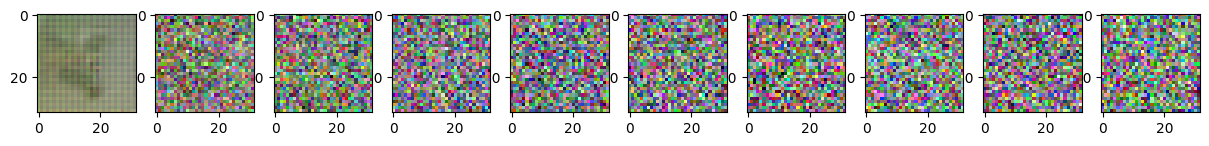

Epoch 0 | step 300 Loss: 0.024070192128419876 


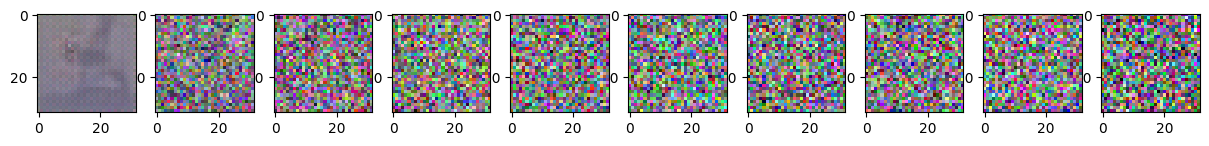

Epoch 0 | step 600 Loss: 0.029890401288866997 


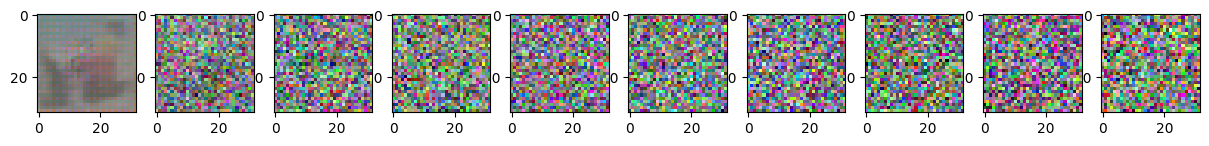

  4%|▍         | 1/25 [01:27<34:51, 87.13s/it]

Epoch 1 | step 000 Loss: 0.03308311104774475 


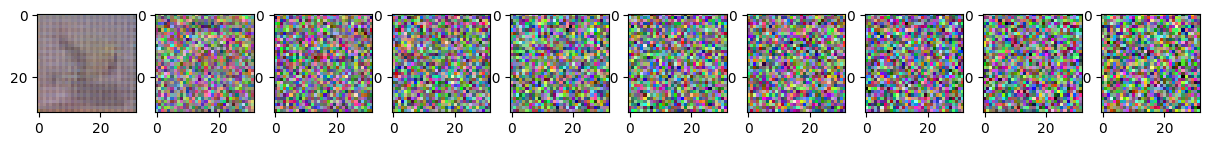

Epoch 1 | step 300 Loss: 0.04618670046329498 


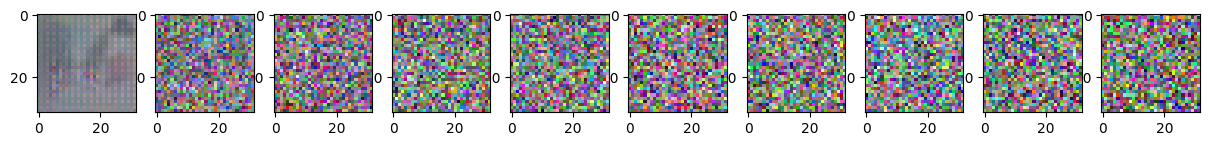

Epoch 1 | step 600 Loss: 0.03471740335226059 


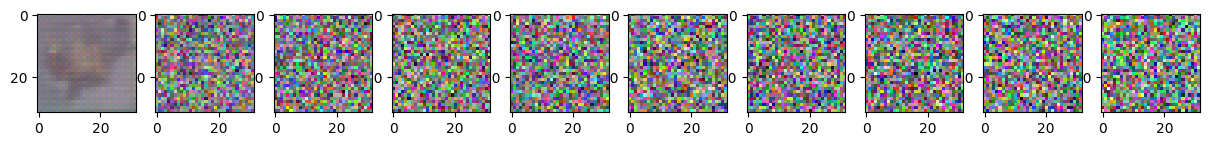

  8%|▊         | 2/25 [02:57<34:06, 88.96s/it]

Epoch 2 | step 000 Loss: 0.03660956770181656 


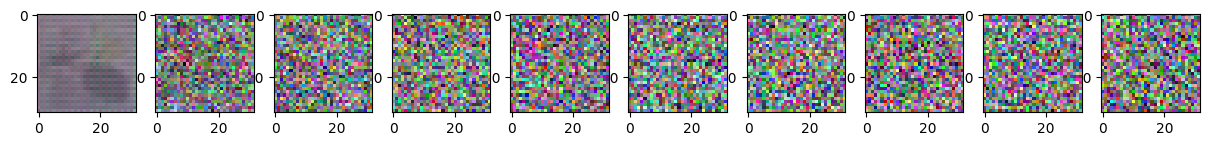

Epoch 2 | step 300 Loss: 0.046246789395809174 


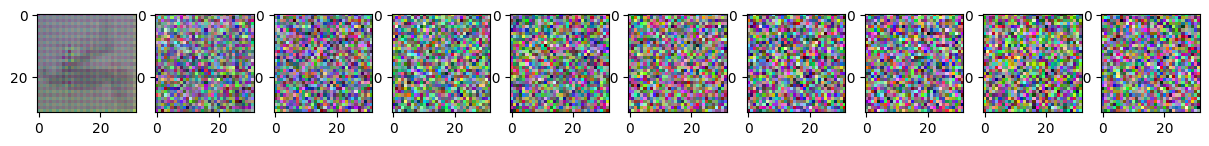

Epoch 2 | step 600 Loss: 0.05171624943614006 


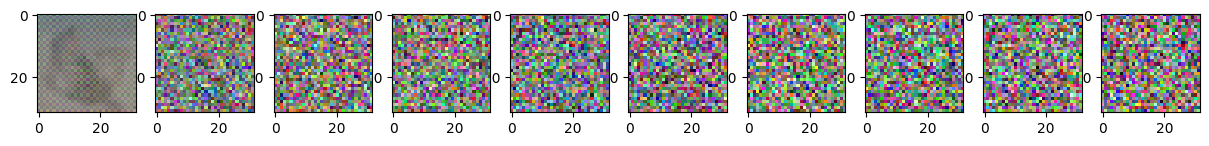

 12%|█▏        | 3/25 [04:26<32:40, 89.13s/it]

Epoch 3 | step 000 Loss: 0.017174819484353065 


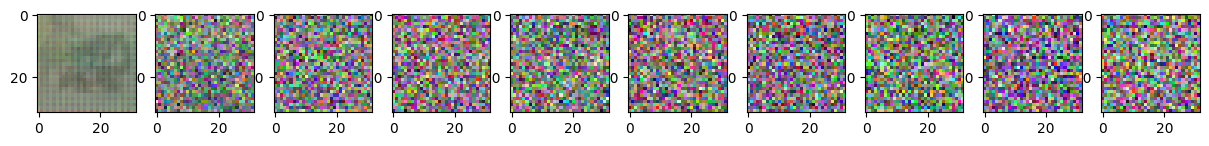

Epoch 3 | step 300 Loss: 0.027567889541387558 


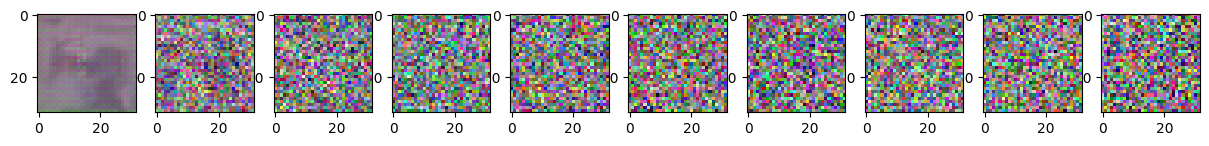

Epoch 3 | step 600 Loss: 0.03966668248176575 


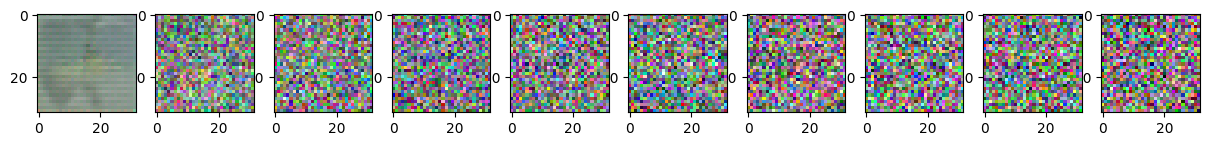

 16%|█▌        | 4/25 [05:55<31:06, 88.89s/it]

Epoch 4 | step 000 Loss: 0.043097108602523804 


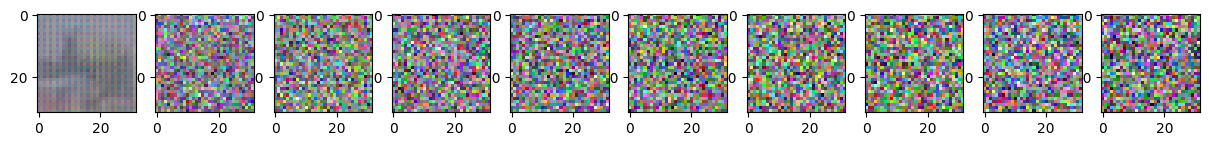

Epoch 4 | step 300 Loss: 0.04082744941115379 


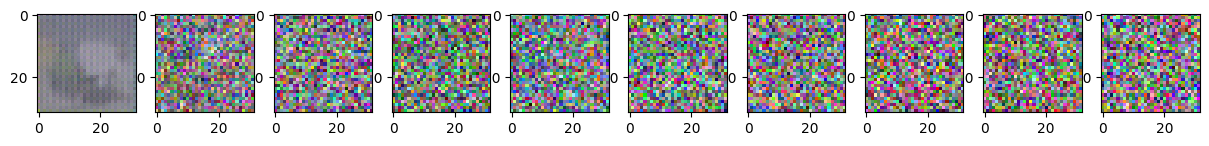

Epoch 4 | step 600 Loss: 0.032182928174734116 


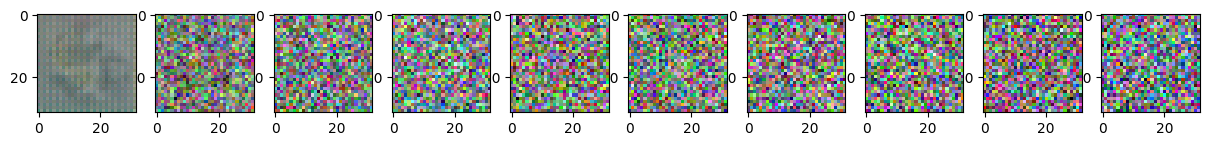

 20%|██        | 5/25 [07:25<29:46, 89.31s/it]

Epoch 5 | step 000 Loss: 0.04217902570962906 


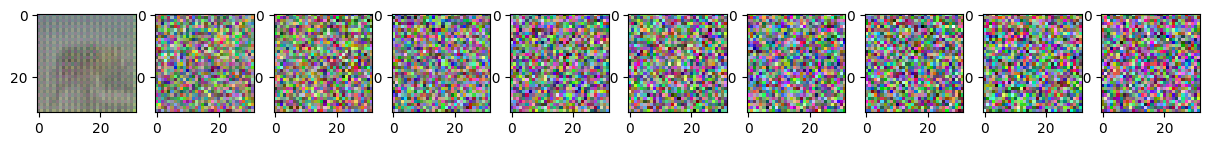

Epoch 5 | step 300 Loss: 0.03351034224033356 


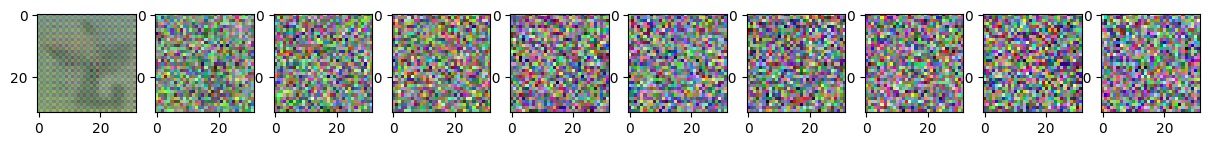

Epoch 5 | step 600 Loss: 0.042690377682447433 


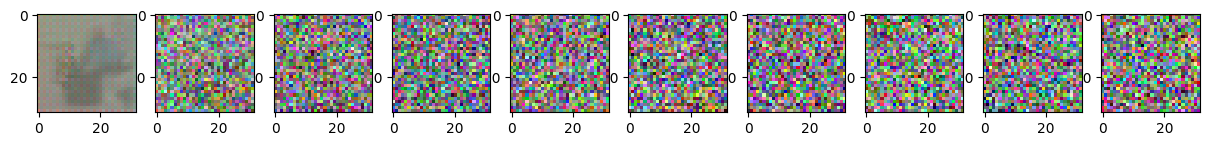

 24%|██▍       | 6/25 [15:06<1:08:21, 215.85s/it]

Epoch 6 | step 000 Loss: 0.030946727842092514 


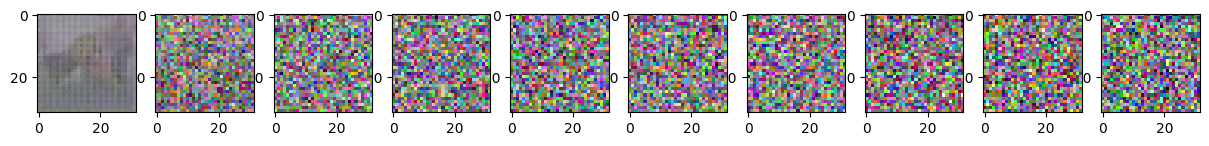

Epoch 6 | step 300 Loss: 0.03212535008788109 


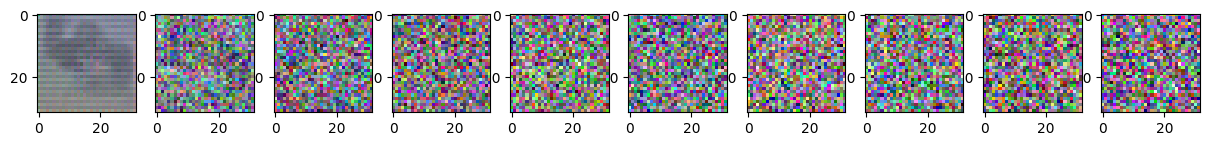

Epoch 6 | step 600 Loss: 0.02310808002948761 


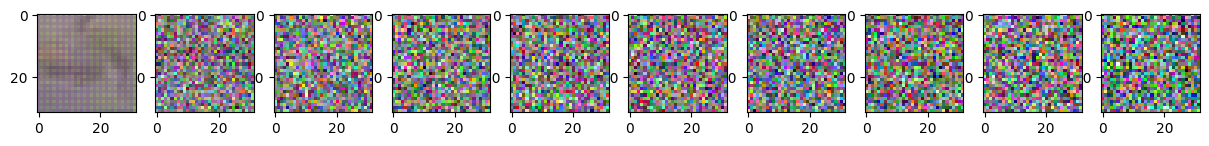

 28%|██▊       | 7/25 [16:35<52:15, 174.20s/it]  

Epoch 7 | step 000 Loss: 0.052151620388031006 


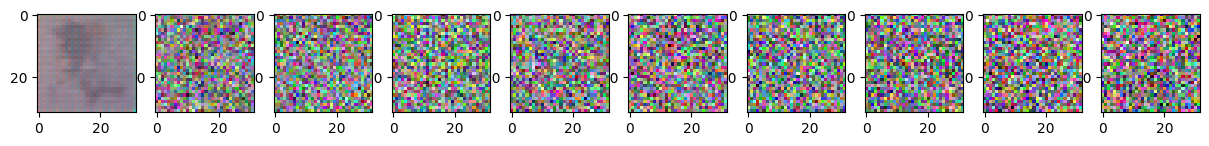

Epoch 7 | step 300 Loss: 0.037507396191358566 


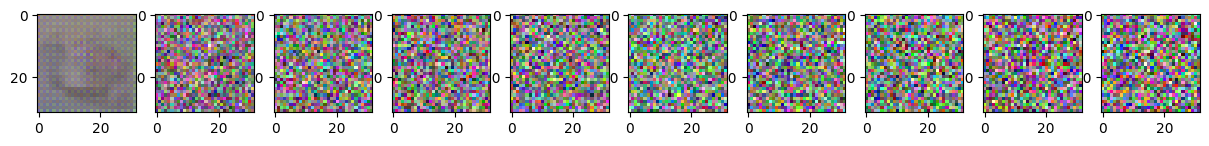

Epoch 7 | step 600 Loss: 0.03987027704715729 


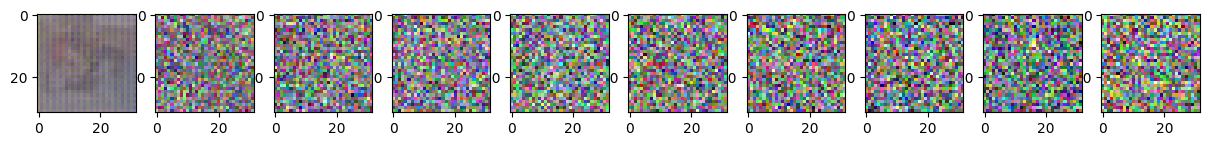

 32%|███▏      | 8/25 [18:05<41:48, 147.57s/it]

Epoch 8 | step 000 Loss: 0.03480834886431694 


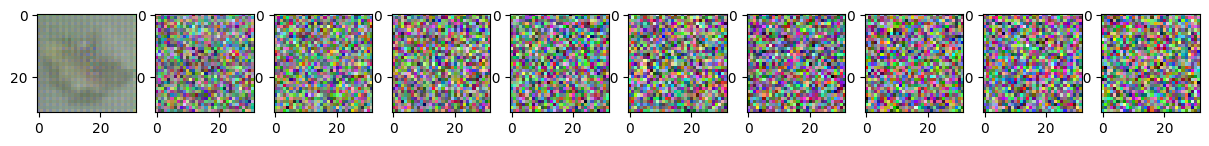

Epoch 8 | step 300 Loss: 0.04535452648997307 


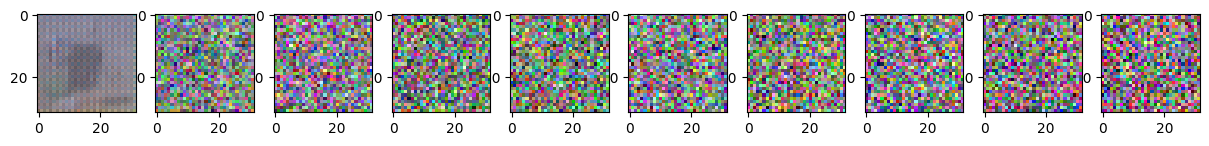

Epoch 8 | step 600 Loss: 0.033186767250299454 


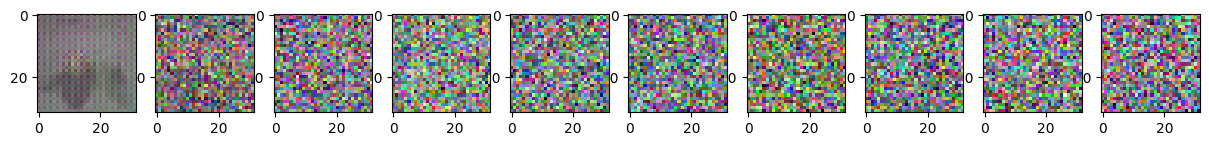

 36%|███▌      | 9/25 [19:35<34:31, 129.45s/it]

Epoch 9 | step 000 Loss: 0.03022797964513302 


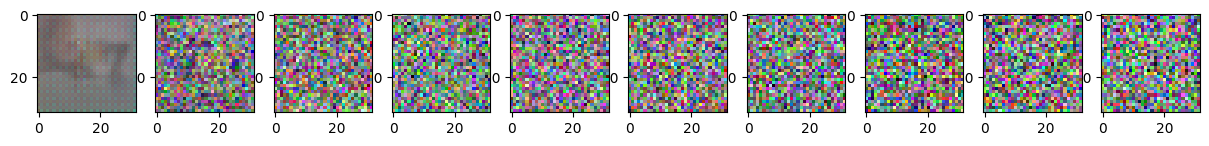

Epoch 9 | step 300 Loss: 0.03421320393681526 


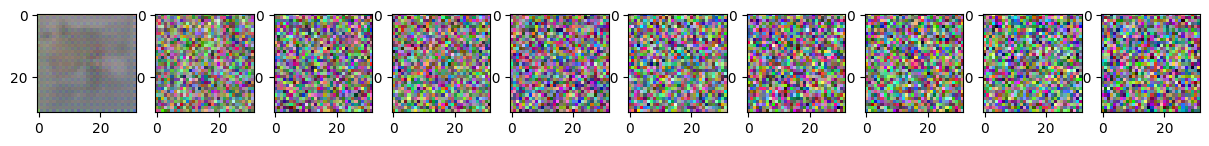

Epoch 9 | step 600 Loss: 0.04422089457511902 


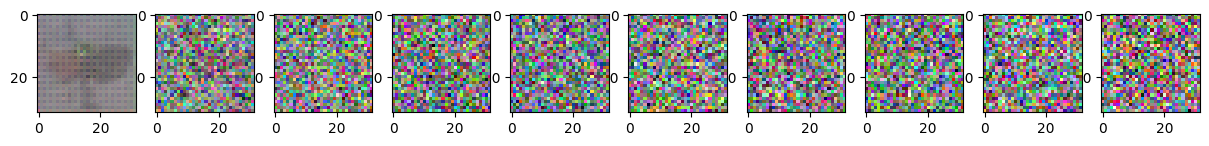

 40%|████      | 10/25 [21:03<29:12, 116.81s/it]

Epoch 10 | step 000 Loss: 0.01836879551410675 


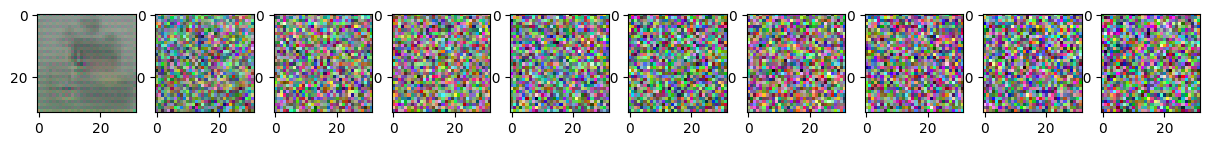

Epoch 10 | step 300 Loss: 0.03976699709892273 


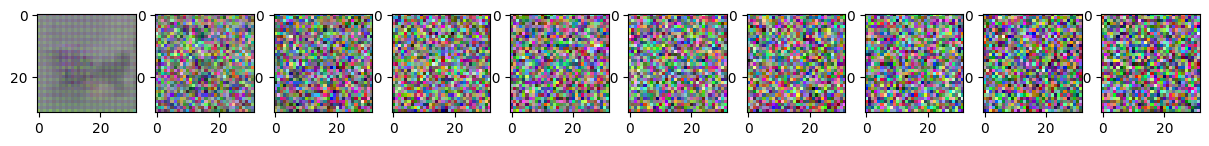

Epoch 10 | step 600 Loss: 0.03707728534936905 


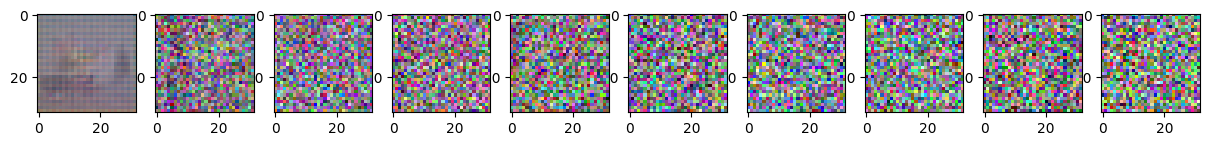

 44%|████▍     | 11/25 [28:37<51:18, 219.89s/it]

Epoch 11 | step 000 Loss: 0.038870301097631454 


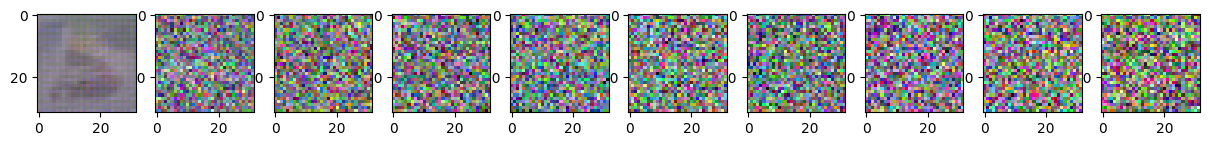

Epoch 11 | step 300 Loss: 0.047321539372205734 


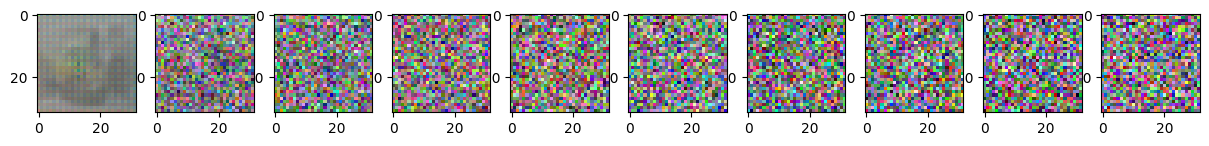

Epoch 11 | step 600 Loss: 0.03320237994194031 


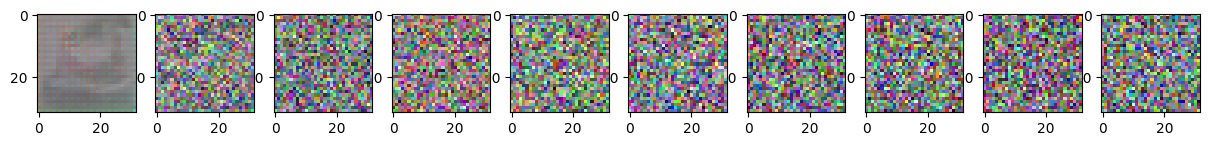

 48%|████▊     | 12/25 [30:07<39:05, 180.39s/it]

Epoch 12 | step 000 Loss: 0.031340137124061584 


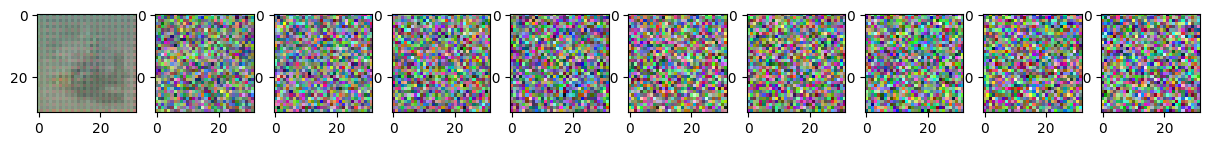

Epoch 12 | step 300 Loss: 0.033813055604696274 


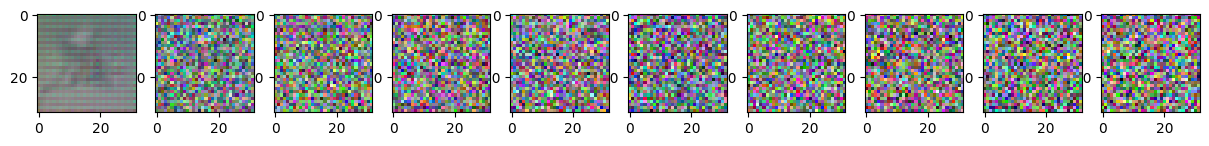

Epoch 12 | step 600 Loss: 0.051885128021240234 


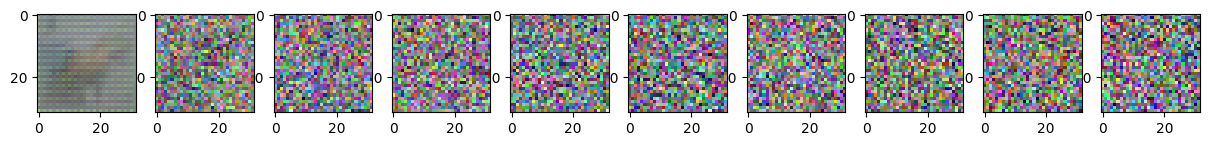

 52%|█████▏    | 13/25 [31:37<30:35, 152.93s/it]

Epoch 13 | step 000 Loss: 0.0394098125398159 


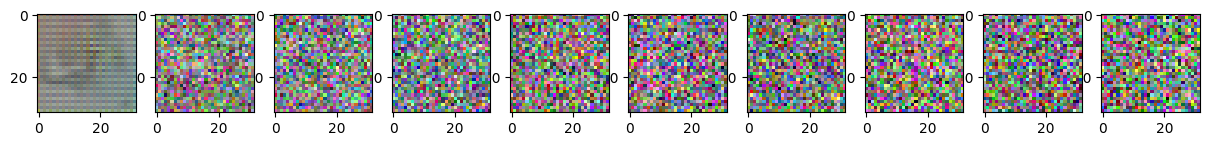

Epoch 13 | step 300 Loss: 0.019270455464720726 


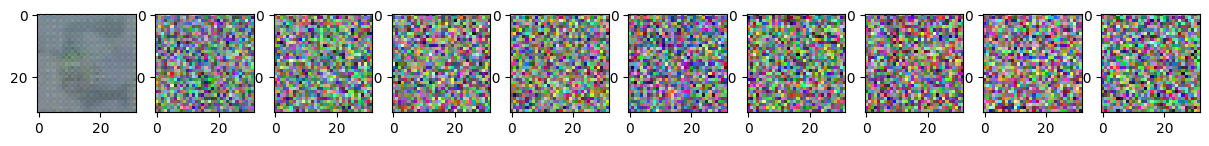

Epoch 13 | step 600 Loss: 0.028830841183662415 


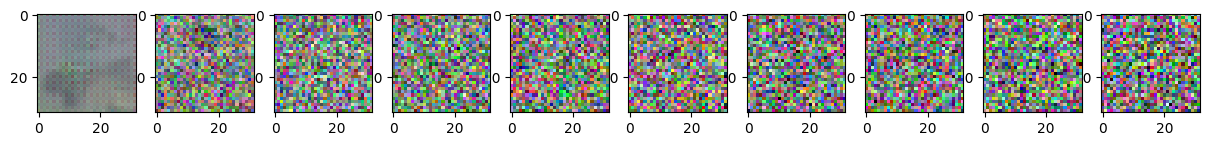

 56%|█████▌    | 14/25 [33:05<24:28, 133.46s/it]

Epoch 14 | step 000 Loss: 0.05409100279211998 


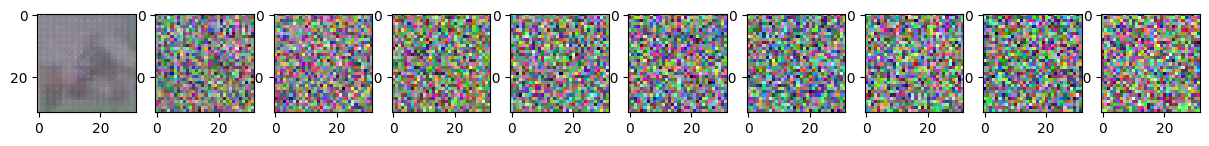

Epoch 14 | step 300 Loss: 0.01814989373087883 


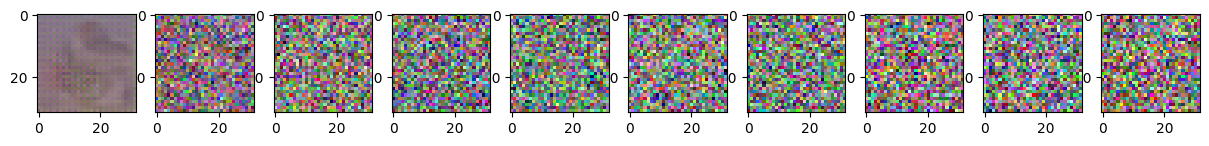

Epoch 14 | step 600 Loss: 0.04611469805240631 


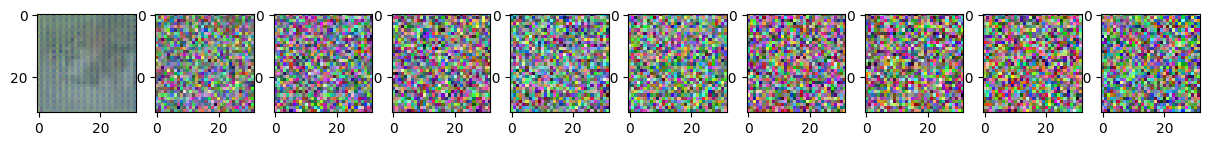

 60%|██████    | 15/25 [34:36<20:04, 120.43s/it]

Epoch 15 | step 000 Loss: 0.03514832258224487 


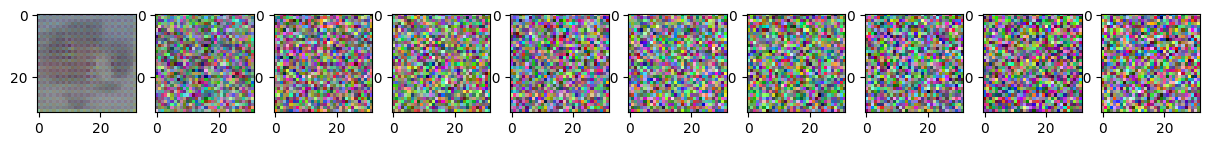

Epoch 15 | step 300 Loss: 0.028346847742795944 


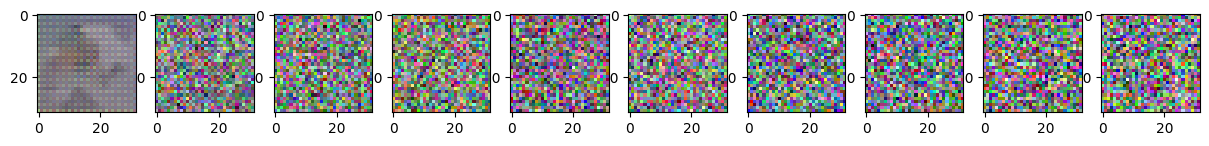

Epoch 15 | step 600 Loss: 0.030123483389616013 


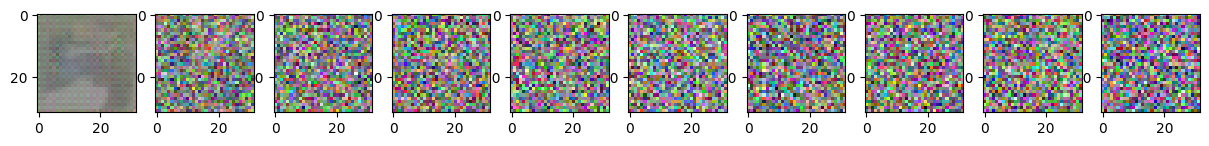

 64%|██████▍   | 16/25 [42:22<33:41, 224.66s/it]

Epoch 16 | step 000 Loss: 0.047126978635787964 


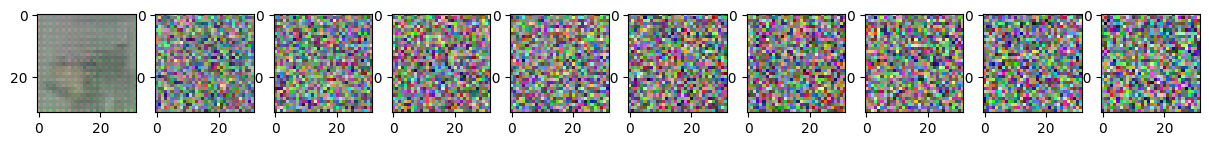

Epoch 16 | step 300 Loss: 0.03104526922106743 


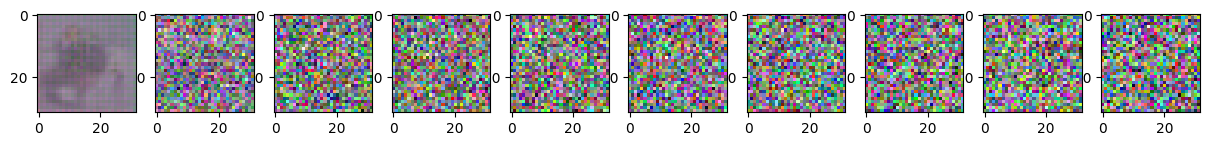

Epoch 16 | step 600 Loss: 0.034134406596422195 


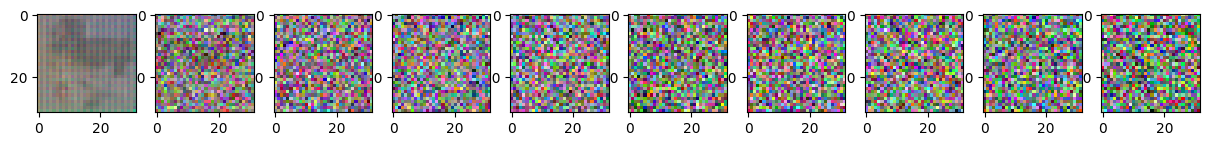

 68%|██████▊   | 17/25 [43:51<24:30, 183.80s/it]

Epoch 17 | step 000 Loss: 0.03290771320462227 


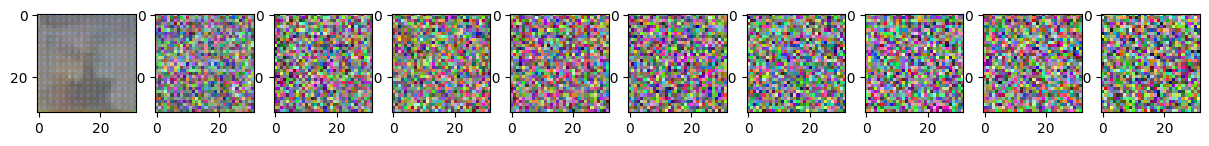

Epoch 17 | step 300 Loss: 0.03853307291865349 


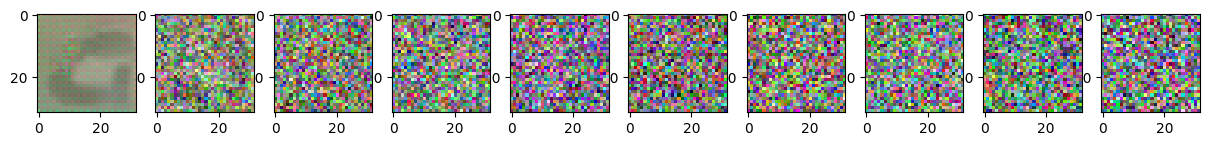

Epoch 17 | step 600 Loss: 0.058162808418273926 


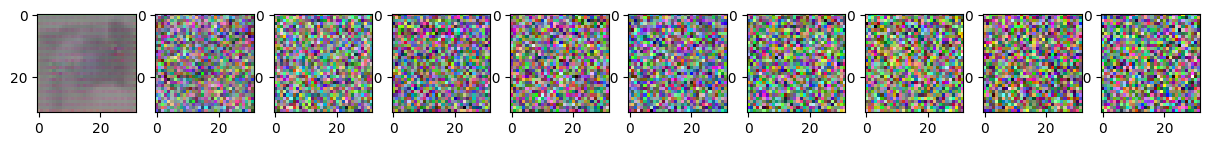

 72%|███████▏  | 18/25 [45:20<18:07, 155.35s/it]

Epoch 18 | step 000 Loss: 0.037050072103738785 


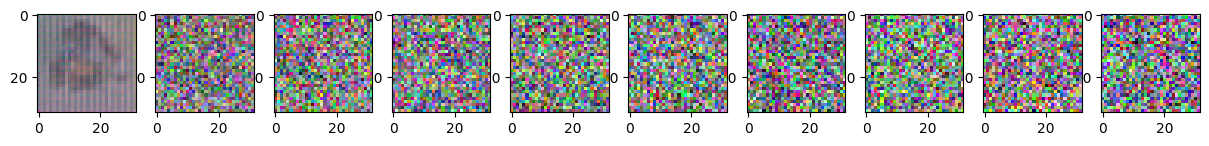

Epoch 18 | step 300 Loss: 0.0483730249106884 


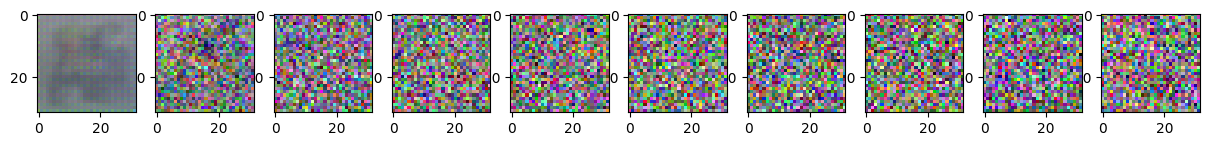

Epoch 18 | step 600 Loss: 0.0321773886680603 


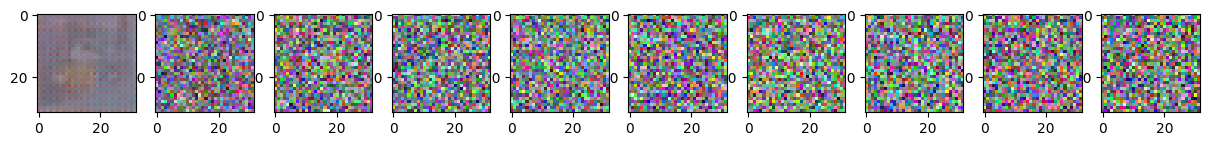

 76%|███████▌  | 19/25 [46:51<13:35, 135.85s/it]

Epoch 19 | step 000 Loss: 0.04005712270736694 


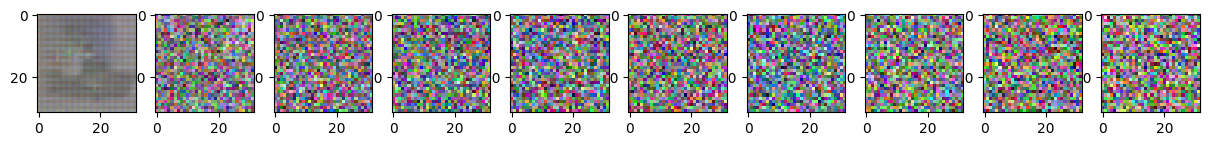

Epoch 19 | step 300 Loss: 0.042303211987018585 


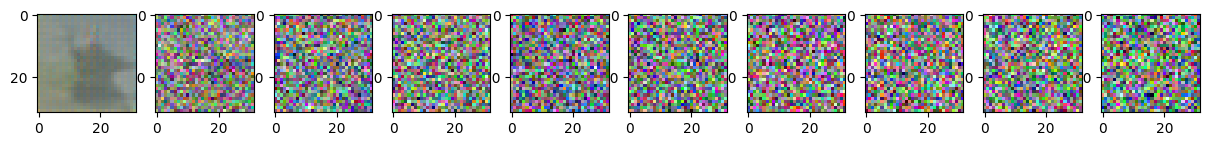

Epoch 19 | step 600 Loss: 0.031234024092555046 


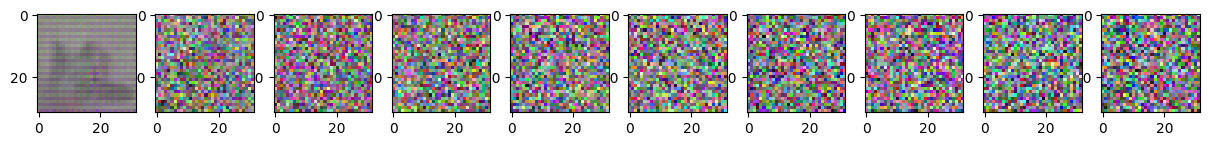

 80%|████████  | 20/25 [48:20<10:09, 121.83s/it]

Epoch 20 | step 000 Loss: 0.04514053091406822 


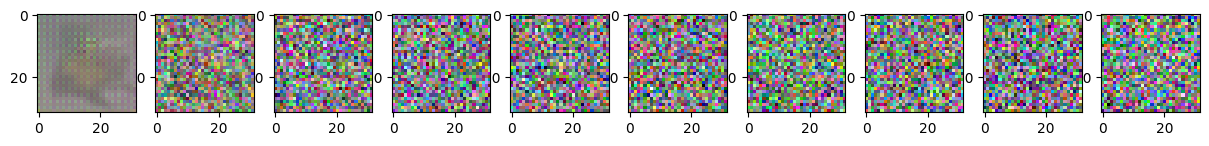

Epoch 20 | step 300 Loss: 0.03216901794075966 


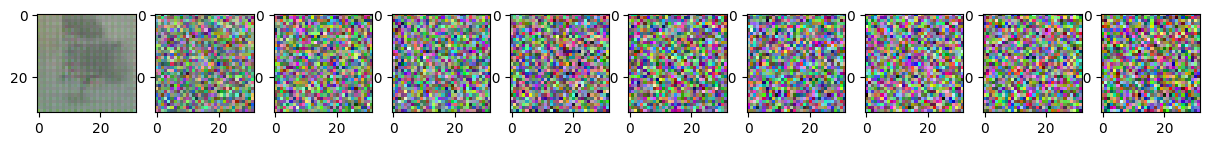

Epoch 20 | step 600 Loss: 0.03611856698989868 


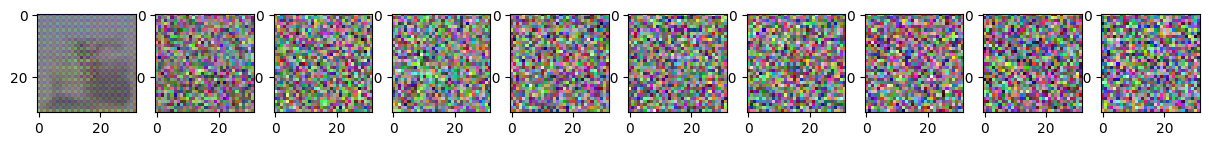

 84%|████████▍ | 21/25 [56:33<15:33, 233.48s/it]

Epoch 21 | step 000 Loss: 0.05372680351138115 


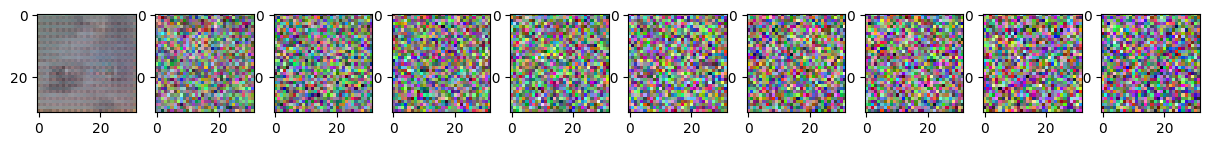

Epoch 21 | step 300 Loss: 0.04425348341464996 


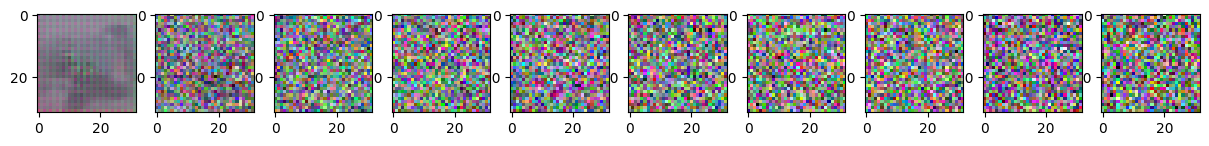

Epoch 21 | step 600 Loss: 0.03333877772092819 


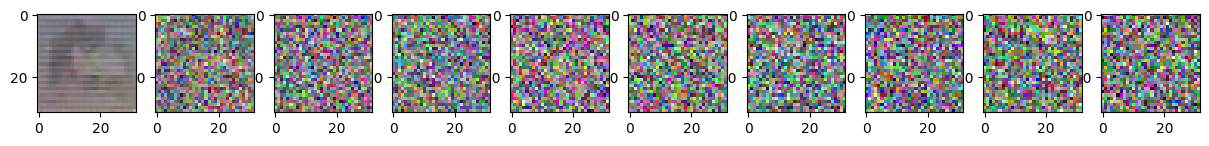

 88%|████████▊ | 22/25 [58:04<09:31, 190.51s/it]

Epoch 22 | step 000 Loss: 0.04512579366564751 


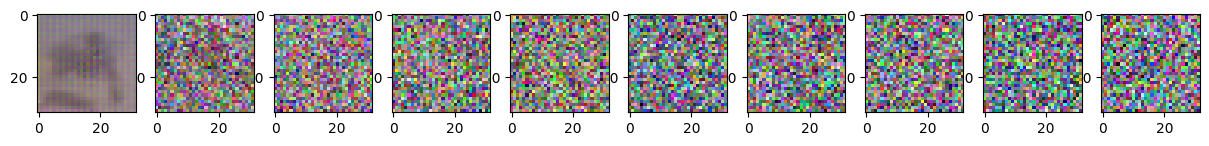

Epoch 22 | step 300 Loss: 0.05269503593444824 


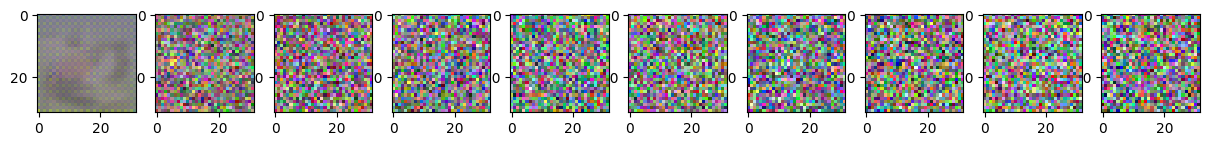

Epoch 22 | step 600 Loss: 0.044990360736846924 


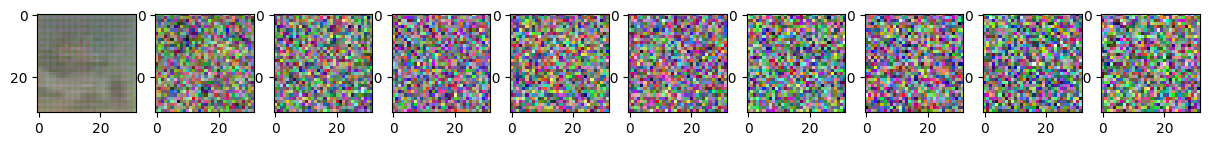

 92%|█████████▏| 23/25 [59:34<05:20, 160.27s/it]

Epoch 23 | step 000 Loss: 0.035844314843416214 


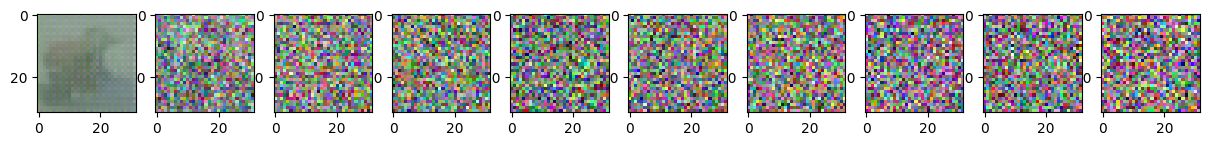

Epoch 23 | step 300 Loss: 0.03968700021505356 


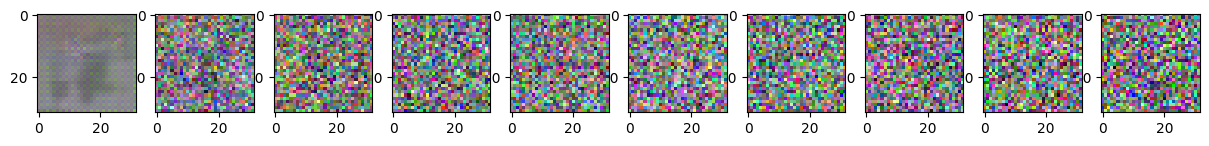

Epoch 23 | step 600 Loss: 0.030910618603229523 


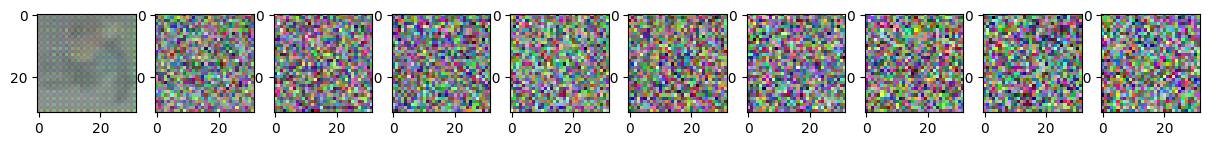

 96%|█████████▌| 24/25 [1:01:02<02:18, 138.72s/it]

Epoch 24 | step 000 Loss: 0.047302551567554474 


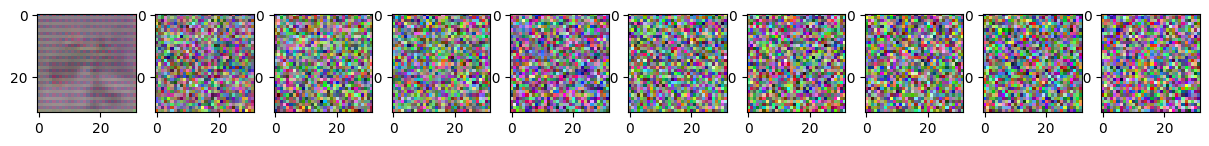

Epoch 24 | step 300 Loss: 0.034326132386922836 


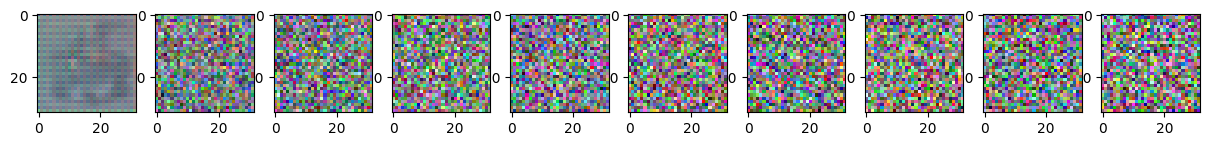

Epoch 24 | step 600 Loss: 0.06305371969938278 


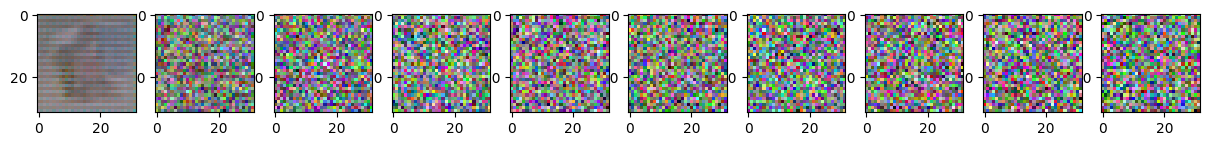

100%|██████████| 25/25 [1:02:32<00:00, 150.10s/it]


In [ ]:
diffusion.train(25, pretrained_epochs=155, save_freq=5, lr=0.0002)

In [ ]:
path_dir='/content/drive/MyDrive/colab/diffusion_cifar10/'
path_now = path_dir + "diffusin_cifar_" + str(155) + "ep.pth"
torch.save(diffusion.model.state_dict(), path_now)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')